# Libraries

In [1]:
from PIL import Image, ImageFilter
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Load Images

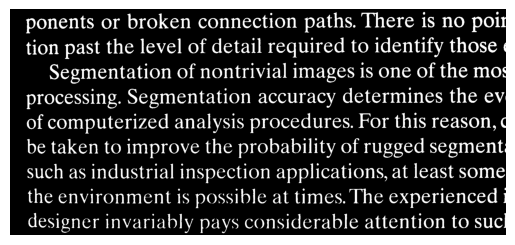

In [2]:
img1 = cv2.imread('text.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

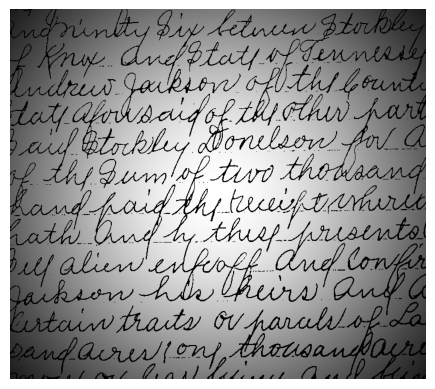

In [ ]:
img2 = cv2.imread('text-spotshade.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()

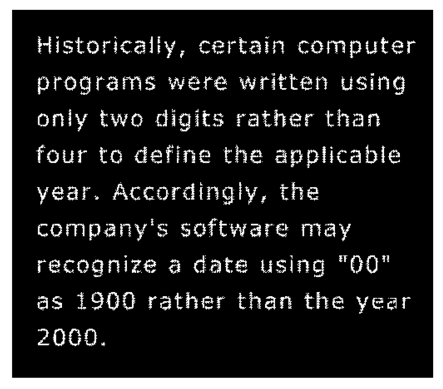

In [4]:
img3 = cv2.imread('text-broken.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.show()

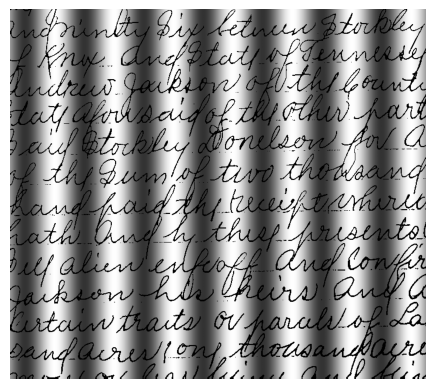

In [5]:
img4 = cv2.imread('text-sineshade.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img4, cmap='gray')
plt.axis('off')
plt.show()

# Useful Functions

In [6]:
def ocr(img):
    img = Image.fromarray(img, mode='L')
    return pytesseract.image_to_string(img)
    
def border_cleaning(img):    
    # Convert the image to uint8
    image = img.astype(np.uint8)
    
    # Find all connected components (objects) in the image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    # Create an output image to store the border-touching objects
    border_objects = np.zeros_like(image)
    
    # Get the dimensions of the image
    height, width = image.shape
    
    # Iterate through each component
    for i in range(1, num_labels):  # Start from 1 to skip the background
        x, y, w, h, area = stats[i]
        
        # Check if the component touches the border
        if x == 0 or y == 0 or (x + w) == width or (y + h) == height:
            # Add the component to the output image
            border_objects[labels == i] = 255
        
    result_array = image - border_objects
    
    return result_array
    
def dilate_image(img):
    img = Image.fromarray(img)
    dilated_img = img.filter(ImageFilter.MaxFilter(3))
    return np.array(dilated_img)

def local_thresholding(img, window_size=20, c=0.5):
    thresholded_img = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Define the window boundaries
            i_min = max(i - window_size // 2, 0)
            i_max = min(i + window_size // 2, img.shape[0] - 1)
            j_min = max(j - window_size // 2, 0)
            j_max = min(j + window_size // 2, img.shape[1] - 1)
            
            # Calculate the local mean
            local_mean = np.mean(img[i_min:i_max+1, j_min:j_max+1])
            
            # Apply the threshold with constant c
            if img[i, j] > local_mean - c:
                thresholded_img[i, j] = 255
            else:
                thresholded_img[i, j] = 0

    return thresholded_img

def moving_threshold(f, n, k):
    f = f.copy()
    assert n >= 1, "n must be greater than or equal to 1"
    assert 0 < k < 1, "k must be between 0 and 1"

    shape = f.shape
    f[1:-1:2, :] = np.fliplr(f[1:-1:2, :])
    f = f.flatten()

    maf = np.ones(n) / n
    res_filter = lfilter(maf, 1, f)

    g = (f > k * res_filter).astype(np.uint8)
    g = g.reshape(shape)
    g[1:-1:2, :] = np.fliplr(g[1:-1:2, :])
    g = g * 255

    return g

### Florence-2

In [12]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import torch

model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

def florence_ocr(cv2_img):
    image = Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    results = run_example(image, task_prompt='<OCR>')
    return results['<OCR>']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


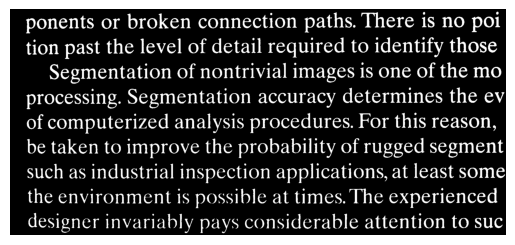

ponents or broken connection paths. There is no poi
tion past the level of detail required to identify those
Segmentation of nontrivial images is one of the mo
processing. Segmentation accuracy determines the ev
of computerized analysis procedures. For this reason,
be taken to improve the probability of rugged segment
such as industrial inspection applications, at least some
the environment is possible at times. The experienced
designer invariably pays considerable attention to suc



In [8]:
clear_img1 = border_cleaning(img1)
plt.imshow(clear_img1, cmap='gray')
plt.axis('off')
plt.show()

text1 = ocr(clear_img1)
print(text1)

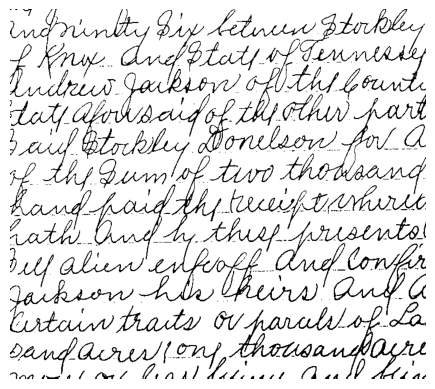

ndrinity Siy letenue Storbley
Knx. and State of Tennessee
ludrew gakson of the lount
taty ahorlsaid of the other part
aif Storkley Donslson for a
of the Gum of two thodsand
hand paid the receipt to mhurd
ath. and hy thep presento
uf alien enfefoff and Confir
Jakson his theirs anf a
curtain traits or parallel of La
and acreres/on, thousandayre



In [13]:
clear_img2 = moving_threshold(img2, 10, 0.5)
plt.imshow(clear_img2, cmap='gray')
plt.axis('off')
plt.show()

text2 = florence_ocr(clear_img2)
print(text2)

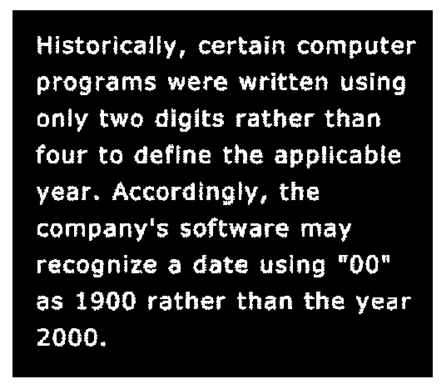

Historically, certain computer
programs were written using
only two digits rather than
four to define the applicable
year. Accordingly, the

company's software may
recognize a date using "00"
as 1960 rather than the year
2000.




In [10]:
dilated_img3 = dilate_image(img3)
plt.imshow(dilated_img3, cmap='gray')
plt.axis('off')
plt.show()

text3 = ocr(dilated_img3)
print(text3)

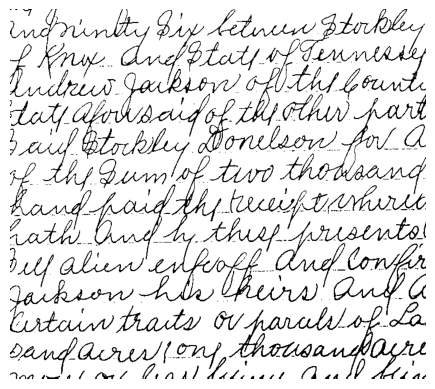

ndrinity Siy letenue Storbley
Knx. and State of Tennessee
ludrew gakson of the lount
taty ahorlsaid of the other part
aif Storkley Donslson for a
of the Gum of two thodsand
hand paid the receipt to mhurd
ath. and hy thep presento
uf alien enfefoff and Confir
Jakson his theirs anf a
curtain traits or parallel of La
and acreres/on, thousandayre



In [14]:
clear_img4 = moving_threshold(img4, 10, 0.5)
plt.imshow(clear_img4, cmap='gray')
plt.axis('off')
plt.show()

text4 = florence_ocr(clear_img4)
print(text4)